##  🏂  [Day 17](https://adventofcode.com/2018/day/17)

In [0]:
import numpy as np

def get_grid(inputs):
  """Translate the puzzle inputs to a numpy array. The coding is as follows:
      -1 : wet sand (water flowing down)
       0 : dry sand
       1 : wet sand (water flowing horizontally)
       2 : clay wall
       3 : wet sand (water enclosed between clay)
       4 : source (for display only)
  """
  coords = []
  minx, maxx = 100000, 0
  miny, maxy = 100000, 0
  # Parse coordinates
  for line in inputs:
    if line.strip():
      fst, snd = line.split(', ')
      fst_coords = int(fst[2:])
      snd_coords = list(map(int, snd.split('=')[1].split('..')))
      if fst[0] == 'y':
        minx = min(minx, fst_coords)
        maxx = max(maxx, fst_coords)
        miny = min(miny, snd_coords[0])
        maxy = max(maxy, snd_coords[1])
        coords.append((fst_coords, np.arange(snd_coords[0], snd_coords[1] + 1)))
      else:
        minx = min(minx, snd_coords[0])
        maxx = max(maxx, snd_coords[1])
        miny = min(miny, fst_coords)
        maxy = max(maxy, fst_coords)
        coords.append((np.arange(snd_coords[0], snd_coords[1] + 1), fst_coords))
  # Build grid, leaving a line at the top for the source
  minx -= 1
  miny -= 2
  maxy += 2
  grid = np.zeros((maxx + 1 - minx, maxy + 1 - miny))
  for x, y in coords:
    grid[x - minx, y - miny] = 2
  # Add fake wall on the side
  grid[:, 0] = 2
  grid[:, -1] = 2
  return grid, miny


"""Print the grid in a readable format"""
encoding = {-1: '|', 0: '.', 1: '~', 2: '#', 3: '_', 4: '+'}    
def print_grid(grid, sources=None):
  global encoding
  if sources is not None:
    for s in sources:
      grid[s[0], s[1]] = 4
  print('\n'.join(''.join(list(map(lambda x: encoding[x], line))) for line in grid))
  
  
"""Matplotlib display (optional)"""
def display_grid(grid, sources=None):
  from matplotlib import pyplot as plt
  from matplotlib.colors import LinearSegmentedColormap
  custom_cmap = ['xkcd:wheat', 'xkcd:white', 'xkcd:goldenrod', 'xkcd:blue', 'orange'] 
  custom_cmap = LinearSegmentedColormap.from_list('water', custom_cmap, N=5)
  plt.figure(figsize=(16, 16 * int(grid.shape[0] / grid.shape[1])))
  if sources is not None:
    for s in sources:
      grid[s[0], s[1]] = 4   
  plt.imshow(grid[:, 1:-1], cmap=custom_cmap)
  plt.axis('off')
  plt.show()

In [0]:
def flow_down_grid(x, y, grid, reset_source):
  """Flow water down the grid from point (x, y).
  Returns the next flow sources to consider"""
  col = grid[x:, y] > 1
  sources = []
  
  ## Flow down the grid until meet clay
  if np.sum(col):
    x_stop = np.argmax(col) + x
    grid[x:x_stop, y] = -1
    
    ## Find first clay borders on the left and right side
    left_wall = np.argmax(grid[x_stop - 1, y::-1] > 1)
    left_hole = np.argmin(grid[x_stop, y::-1] > 1)
    right_wall = np.argmax(grid[x_stop - 1, y:] > 1)
    right_hole = np.argmin(grid[x_stop, y:] > 1)

    ## Add new water sources if water is overflowing
    overflow = False
    if left_hole < left_wall:
      overflow = True
      sources.append((x_stop - 1, y - left_hole))

    if right_hole < right_wall:
      overflow = True
      sources.append((x_stop - 1, y + right_hole))

    ## Fill water
    if overflow:
      grid[x_stop - 1, y - min(left_hole, left_wall) + 1:y + min(right_hole, right_wall)] = 1
    else:
      # If blocked by clay, fill the full "recipient"
      # find out maximum extent of the left and right wall
      max_wall_top = min(np.argmin(grid[x_stop::-1, y - left_wall] > 1),
                         np.argmin(grid[x_stop::-1, y + right_wall] > 1)) - 1
      max_wall_top = x_stop - max_wall_top
      if max_wall_top > 0:
        # fill water until the highest part where there's no other obstacle between the left and right wall
        # (avoid filling empty zones)
        num_obstacles = np.sum(grid[x_stop - 1:max_wall_top - 1:-1, 
                                    y - left_wall + 1:y + right_wall] == 2, axis=1) > 0
        if np.sum(num_obstacles) == 0:
          wall_top = max_wall_top
        else:
          wall_top = x_stop - np.argmax(num_obstacles)
        # Flood everything inside the region except for walls
        grid[wall_top:x_stop, y - left_wall + 1: y + right_wall][
            grid[wall_top:x_stop, y - left_wall + 1: y + right_wall] != 2] = 3
        # Add sources   
        if wall_top < x: # if source is immerged, reset to the original source
          sources.append(reset_source)
        else:            # otherwise, continue flowing from current source
          sources.append((x, y))   
  ## If no obstacles, flow to the end
  else:
    grid[x:, y] = -1
  return sources
 
    
def water_flow(inputs, source=500, limit_steps=2000000, verbose=0):
  """Flow the water down the grid until done, or limit_steps reached"""
  # Initial source
  grid, miny = get_grid(inputs)
  reset_source = (0, source - miny)
  sources = [reset_source]
  
  # Flood
  i = 0
  while len(sources):
    # Find next sources
    next_sources = []
    for s in sources:
      next_sources.extend(flow_down_grid(s[0], s[1], grid, reset_source))
    i += 1
    sources = set(next_sources)
    # Display
    if verbose == 2:
      print()
      print_grid(np.copy(grid), sources)
      
  # Compute number of flooded tiles (remove one because of the extra first row for the intilial source)
  num_undrained_tiles = np.sum(grid == 3)
  num_water_tiles = np.sum((grid == -1) | (grid == 1)) + num_undrained_tiles - 1 
  print('Number of flooded tiles: %d and remaining undrained tiles: %d' % (
      num_water_tiles, num_undrained_tiles))      
  # Final display
  if verbose >= 1:
    print()
    print_grid(np.copy(grid), sources)
  else:
    display_grid(np.copy(grid), sources)

Number of flooded tiles: 30737 and remaining undrained tiles: 24699


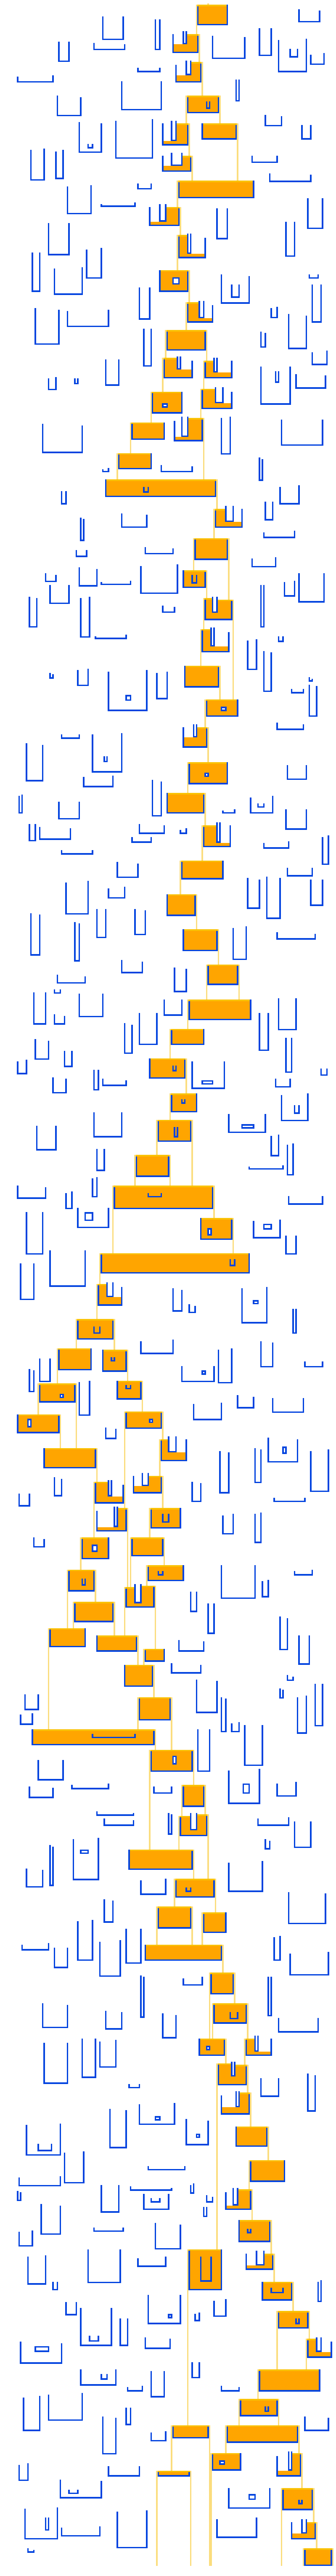

CPU times: user 2.2 s, sys: 263 ms, total: 2.46 s
Wall time: 3.76 s


In [3]:
%%time
with open("day17.txt", 'r') as f: 
  inputs = f.read().splitlines()
water_flow(inputs, source=500, limit_steps=400, verbose=False)